# Data Prcoessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.colors
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
from sklearn.preprocessing import MinMaxScaler

raw_data = pd.read_csv('dataset_2(cleaned).csv')
raw_data_no_constant = raw_data.drop(columns=['DD_S315','PEDOT_spd','PEDOT_rt','DD_IPA','DD_ZnO','DD_PV416','DD_PGMEA','Web_speed_Grid','Web_speed_Active','Web_speed_ETL','Flow0_ETL','Grid_rt','pos','block_num','index','pce'])
raw_data_no_collinearity = raw_data_no_constant.drop(columns=['TDD of active','Humidity_ETL','Active_humid','Donor fraction','Electrode_amb_dep_T','T_air_Grid','Active_amb_dep_T','T_air_ETL','Electrode_dep_humidity','Grid_Dep_Humidity','Flow0_Active','Flow1_Active','Flow2_Active'])

# Drop the first 3 rows as it is the only duplicated data, also indicating the machine is starting
raw_data_no_collinearity_manufacture_unnormal = raw_data_no_collinearity.iloc[3:].reset_index(drop=True)
raw_data_no_collinearity_manufacture_unnormal['jsc'] = raw_data_no_collinearity_manufacture_unnormal['jsc'].abs()
raw_data_no_collinearity_manufacture_unnormal.rename(columns={'ff': 'FF', 'jsc': 'JSC', 'voc': 'VOC'}, inplace=True)
scaler = MinMaxScaler()
raw_data_no_collinearity_manufacture = pd.DataFrame(scaler.fit_transform(raw_data_no_collinearity_manufacture_unnormal), columns=raw_data_no_collinearity_manufacture_unnormal.columns)

In [2]:
print(raw_data_no_collinearity_manufacture_unnormal['FF'].max())
print(raw_data_no_collinearity_manufacture_unnormal['FF'].min())
dataset_ff = raw_data_no_collinearity_manufacture.drop(columns=['JSC','VOC'])

69.0982526
0.0


In [3]:
print(raw_data_no_collinearity_manufacture_unnormal['VOC'].max())
print(raw_data_no_collinearity_manufacture_unnormal['VOC'].min())
dataset_voc = raw_data_no_collinearity_manufacture.drop(columns=['JSC','FF'])

0.953517288
0.0


In [4]:
print(raw_data_no_collinearity_manufacture_unnormal['JSC'].max())
print(raw_data_no_collinearity_manufacture_unnormal['JSC'].min())
dataset_jsc = raw_data_no_collinearity_manufacture.drop(columns=['FF','VOC'])

28.80501905
0.000705576


# Bayesian Optimisation

In [10]:
import numpy as np
import pandas as pd
import pickle
import torch
import gpytorch
import os
import time
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed

# Define Gaussian Process Model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define Expected Improvement
def expected_improvement(X, X_sample, Y_sample, model, xi=0.1):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).cuda()
        if X_tensor.dim() == 1:
            X_tensor = X_tensor.unsqueeze(0) 

        mu, sigma = model(X_tensor).mean.cpu().numpy(), model(X_tensor).variance.sqrt().cpu().numpy()
        mu_sample_opt = np.max(Y_sample)

        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

# Define function to propose the next sampling location
def propose_location(acquisition, X_sample, Y_sample, model, bounds, n_restarts=100):
    dim = X_sample.shape[1]
    min_x = None

    def min_obj(X):
        return -acquisition(X, X_sample, Y_sample, model)

    solution = []
    for a in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=a, bounds=bounds, method='SLSQP')
        solution.append((res.fun, tuple(res.x)))
    
    unique_solution = list(set(solution))
    sorted_solution = sorted(unique_solution, key=lambda x: x[0], reverse=True)      
    return sorted_solution

# Calculate weighted average using nearest neighbors
def calculate(X, dataset):
    X_train = dataset.iloc[:, :11].values
    y_train = dataset.iloc[:, 11].values
    
    nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto').fit(X_train) # IMPORTANT!! CHANGED TO 12
    distances, indices = nbrs.kneighbors([X])
    y_neighbors = y_train[indices[0]]
    
    if 0 in distances[0]:
        return y_neighbors[np.argmin(distances[0])]
    
    weights = 1 / distances[0]
    weights /= weights.sum()
    y_pred = np.dot(weights, y_neighbors)
    
    return y_pred

def run_optimization(repetition, dataset):
    # Identify input and target columns
    target_column = dataset.columns[-1]  # Last column is the target variable
    feature_columns = dataset.columns[:-1]  # All other columns are features

    # Create directories for results and time logs
    result_dir = f"Bayesian Opt Result {target_column}"
    time_dir = f"Bayesian Opt Time {target_column}"
    os.makedirs(result_dir, exist_ok=True)
    os.makedirs(time_dir, exist_ok=True)

    # Determine Bounds
    bounds = np.array([[dataset[a].min(), dataset[a].max()] for a in feature_columns])

    # Select random initial samples
    random_indices = np.random.randint(0, len(dataset), size=2)
    X_sample = dataset.iloc[random_indices].drop(columns=[target_column]).reset_index(drop=True)
    Y_sample = dataset.iloc[random_indices][target_column].reset_index(drop=True)

    X_train = torch.tensor(X_sample.values, dtype=torch.float32).cuda()
    Y_train = torch.tensor(Y_sample.values, dtype=torch.float32).cuda()

    # Initialize Gaussian Process Model
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = GPModel(X_train, Y_train, likelihood).cuda()

    iteration_times = []

    # Perform Bayesian Optimization for 25 iterations
    for iteration in range(25):
        start_time = time.time()
        
        # Train GP model
        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, Y_train)
        loss.backward()
        optimizer.step()
        
        model.eval()
        likelihood.eval()
        
        # Suggest next sample
        X_next = propose_location(expected_improvement, X_sample, Y_sample, model, bounds)

        # Update samples with new points
        for a in range(25):
            X_sample.loc[len(X_sample)] = X_next[a][1]
            Y_sample.loc[len(Y_sample)] = calculate(X_next[a][1], dataset)
        
        end_time = time.time()
        iteration_times.append(end_time - start_time)

    os.system('cls' if os.name == 'nt' else 'clear')

    # Save results with target column in folder-specific filenames
    os.makedirs(result_dir, exist_ok=True)
    os.makedirs(time_dir, exist_ok=True)
    result_filename = os.path.join(result_dir, f"bayesian_optimization_{target_column}_results_{repetition}.pkl")
    time_filename = os.path.join(time_dir, f"bayesian_optimization_{target_column}_time_{repetition}.pkl")

    with open(result_filename, "wb") as f:
        pickle.dump((X_sample, Y_sample), f)

    with open(time_filename, "wb") as f:
        pickle.dump(iteration_times, f)

    return f"Repetition {repetition} complete. Avg iteration time: {np.mean(iteration_times):.4f} sec"

num_jobs = 10  # Use 10 cores

# FF

In [78]:
results = Parallel(n_jobs=num_jobs)(
    delayed(run_optimization)(i, dataset_ff) for i in tqdm(range(300), desc="Parallel Repetitions")
)

Parallel Repetitions:   3%|▎         | 10/300 [00:10<00:08, 35.21it/s]

KeyboardInterrupt: 

# VOC

In [15]:
results = Parallel(n_jobs=num_jobs)(
    delayed(run_optimization)(i, dataset_voc) for i in tqdm(range(300), desc="Parallel Repetitions")
)

Parallel Repetitions: 100%|██████████| 300/300 [4:16:55<00:00, 51.38s/it]  


# JSC

In [17]:
results = Parallel(n_jobs=num_jobs)(
    delayed(run_optimization)(i, dataset_jsc) for i in tqdm(range(300), desc="Parallel Repetitions")
)

Parallel Repetitions: 100%|██████████| 300/300 [4:16:38<00:00, 51.33s/it]  


# Random Search

In [19]:
import os
import numpy as np
import pickle
import time
from tqdm import tqdm
from joblib import Parallel, delayed

def random_search(repetition, dataset):
    # Identify the last column as the target variable
    target_column = dataset.columns[-1]

    # Create directories if they don't exist
    result_dir = f"Random Search Result {target_column}"
    time_dir = f"Random Search Time {target_column}"
    os.makedirs(result_dir, exist_ok=True)
    os.makedirs(time_dir, exist_ok=True)

    # Select random initial samples
    random_integers = np.random.randint(0, len(dataset), size=2)
    X_sample = dataset.iloc[random_integers]
    Y_sample = X_sample[target_column].reset_index(drop=True)
    X_sample = X_sample.drop(columns=[target_column]).reset_index(drop=True)

    iteration_times = []

    for a in range(625):
        if a % 25 == 0:
            start_time = time.time()
        
        X_next = np.random.rand(X_sample.shape[1])  # Generate new random sample
        X_sample.loc[len(X_sample)] = X_next
        Y_sample.loc[len(X_sample)] = calculate(X_next, dataset)

        if a % 25 == 24:
            end_time = time.time()
            iteration_times.append(end_time - start_time)

    # Save results
    with open(os.path.join(result_dir, f"random_search_{target_column}_results_{repetition}.pkl"), "wb") as f:
        pickle.dump((X_sample, Y_sample), f)

    with open(os.path.join(time_dir, f"random_search_{target_column}_time_{repetition}.pkl"), "wb") as f:
        pickle.dump(iteration_times, f)

    return f"Repetition {repetition} complete."

# FF

In [21]:
results = Parallel(n_jobs=num_jobs)(
    delayed(random_search)(i, dataset_ff) for i in tqdm(range(300), desc="Parallel Repetitions")
)

Parallel Repetitions: 100%|██████████| 300/300 [05:45<00:00,  1.15s/it]


# VOC

In [23]:
results = Parallel(n_jobs=num_jobs)(
    delayed(random_search)(i, dataset_voc) for i in tqdm(range(300), desc="Parallel Repetitions")
)

Parallel Repetitions: 100%|██████████| 300/300 [05:34<00:00,  1.12s/it]


# JSC

In [25]:
results = Parallel(n_jobs=num_jobs)(
    delayed(random_search)(i, dataset_jsc) for i in tqdm(range(300), desc="Parallel Repetitions")
)

Parallel Repetitions: 100%|██████████| 300/300 [05:35<00:00,  1.12s/it]


# Visualization

In [41]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_max_iterations(folder, title, ax):
    all_cumulative_max = {}
    all_cumulative_max[0] = []
    file_count = 0
    
    for filename in os.listdir(folder):
        if filename.endswith(".pkl"):
            file_path = os.path.join(folder, filename)
            with open(file_path, "rb") as f:
                X_sample, Y_sample = pickle.load(f)
            
            y = Y_sample
            batch_size = 25
            cumulative_max = [max(y[0], y[1])]
            iterations = [0]
            current_max = max(y[0], y[1])
            all_cumulative_max[0].append(current_max)
            
            for i in range(2, len(y), batch_size):
                batch_y = y[i:i+batch_size]
                iteration = (i // batch_size) + 1
                if len(batch_y) > 0:
                    max_y = max(batch_y)
                    current_max = max(current_max, max_y)
                    cumulative_max.append(current_max)
                    iterations.append(iteration)
                    
                    if iteration not in all_cumulative_max:
                        all_cumulative_max[iteration] = []
                    all_cumulative_max[iteration].append(current_max)
            
            ax.plot(iterations, cumulative_max, linestyle='-', alpha=0.2, color='blue')
            file_count += 1
    
    avg_iterations = sorted(all_cumulative_max.keys())
    avg_cumulative_max = [np.mean(all_cumulative_max[it]) for it in avg_iterations]
    ax.plot(avg_iterations, avg_cumulative_max, linestyle='-', color='green', label='Average Max')
    ax.set_facecolor('white')
    ax.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.5) # Major grid lines
    ax.minorticks_on() # Turn on minor ticks
    ax.grid(True, which='minor', color='lightgray', linestyle='-', linewidth=0.4, alpha=0.5) # Minor grid lines
    ax.set_xlabel('Iteration', fontsize=14)
    ax.set_ylabel('Cumulative Max Value', fontsize=14)
    ax.legend()
    ax.tick_params(axis='both', direction='in',which='both')
    ax.set_title(title, fontsize=14)
    for spine in ax.spines.values():
        spine.set_edgecolor('#e7e7e7')

def visualize_max_iterations2(folder, color, label, ax, item, title):
    all_cumulative_max = {}
    all_cumulative_max[0] = []
    
    for filename in os.listdir(folder):
        if filename.endswith(".pkl"):
            file_path = os.path.join(folder, filename)
            with open(file_path, "rb") as f:
                X_sample, Y_sample = pickle.load(f)
            
            y = Y_sample
            batch_size = 25
            cumulative_max = [max(y[0], y[1])]
            iterations = [0]
            current_max = max(y[0], y[1])
            all_cumulative_max[0].append(current_max*(raw_data_no_collinearity_manufacture_unnormal[item].max()-raw_data_no_collinearity_manufacture_unnormal[item].min())+raw_data_no_collinearity_manufacture_unnormal[item].min())
            
            for i in range(2, len(y), batch_size):
                batch_y = y[i:i+batch_size]
                iteration = (i // batch_size) + 1
                
                if len(batch_y) > 0:
                    max_y = max(batch_y)
                    current_max = max(current_max, max_y)
                    cumulative_max.append(current_max)
                    iterations.append(iteration)
                    
                    if iteration not in all_cumulative_max:
                        all_cumulative_max[iteration] = []
                    all_cumulative_max[iteration].append(current_max*(raw_data_no_collinearity_manufacture_unnormal[item].max()-raw_data_no_collinearity_manufacture_unnormal[item].min())+raw_data_no_collinearity_manufacture_unnormal[item].min())
    
    avg_iterations = sorted(all_cumulative_max.keys())
    avg_cumulative_max = [np.mean(all_cumulative_max[it]) for it in avg_iterations]
    ax.plot(avg_iterations, avg_cumulative_max, linestyle='-', color=color, label=label)
    ax.set_facecolor('white')
    ax.set_xlabel('Iteration', fontsize=16)
    ax.set_ylabel('Cumulative max value (' + item +')', fontsize=16)
    ax.grid(True, linestyle='-', alpha=0.6)
    ax.legend()
    ax.set_title(title, fontsize =16)
    ax.grid(True, which='minor', axis='y', color='lightgray', linestyle='-', linewidth=0.4, alpha=0.5)
    ax.tick_params(axis='both', direction='in',which='both')
    ax.minorticks_on()
    for spine in ax.spines.values():
        spine.set_edgecolor('#e7e7e7')

def plot_cdf(df, ax, item, title):
    sorted_item = np.sort(df[item])
    
    cdf = np.arange(1, len(sorted_item) + 1) / len(sorted_item)
    
    # Plot the CDF
    ax.plot(sorted_item*(raw_data_no_collinearity_manufacture_unnormal[item].max()-raw_data_no_collinearity_manufacture_unnormal[item].min())+raw_data_no_collinearity_manufacture_unnormal[item].min(), cdf, marker='.', linestyle='none', color='blue', label='CDF')
    ax.set_title(title, fontsize =16)
    ax.set_xlabel(item , fontsize =16)
    ax.set_ylabel('Cumulative Probability', fontsize =16)
    ax.grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.grid(True, which='minor', color='lightgray', linestyle='-', linewidth=0.4, alpha=0.5)
    ax.legend()
    ax.tick_params(axis='both', direction='in',which='both')
    ax.minorticks_on()
    for spine in ax.spines.values():
        spine.set_edgecolor('#e7e7e7')

def compute_average_time(folder):
    all_samples = []
    
    for filename in os.listdir(folder):
        if filename.endswith(".pkl"):
            file_path = os.path.join(folder, filename)
            with open(file_path, "rb") as f:
                Y_sample = pickle.load(f)
            
            all_samples.append(Y_sample)
    
    max_length = max(len(sample) for sample in all_samples)
    
    padded_samples = [np.pad(sample, (0, max_length - len(sample)), constant_values=np.nan) for sample in all_samples]
    
    all_samples_array = np.array(padded_samples, dtype=np.float64)
    average_values = np.nanmean(all_samples_array, axis=0)
    
    return average_values
    
def plot_time(ax, folder, label, marker, color, title):
    a = list(compute_average_time(folder))
    ax.plot(range(1, len(a)+1), a, label=label, marker=marker, color=color)
    
    ax.grid(True, linestyle='-', alpha=0.6)
    ax.set_xlabel('Iterations', fontsize=16)
    ax.set_ylabel('Time (s)', fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.legend()
    ax.tick_params(axis='both', direction='in',which='both')
    ax.minorticks_on()
    ax.grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.grid(True, which='minor', color='lightgray', linestyle='-', linewidth=0.4, alpha=0.5)
    for spine in ax.spines.values():
        spine.set_edgecolor('#e7e7e7')

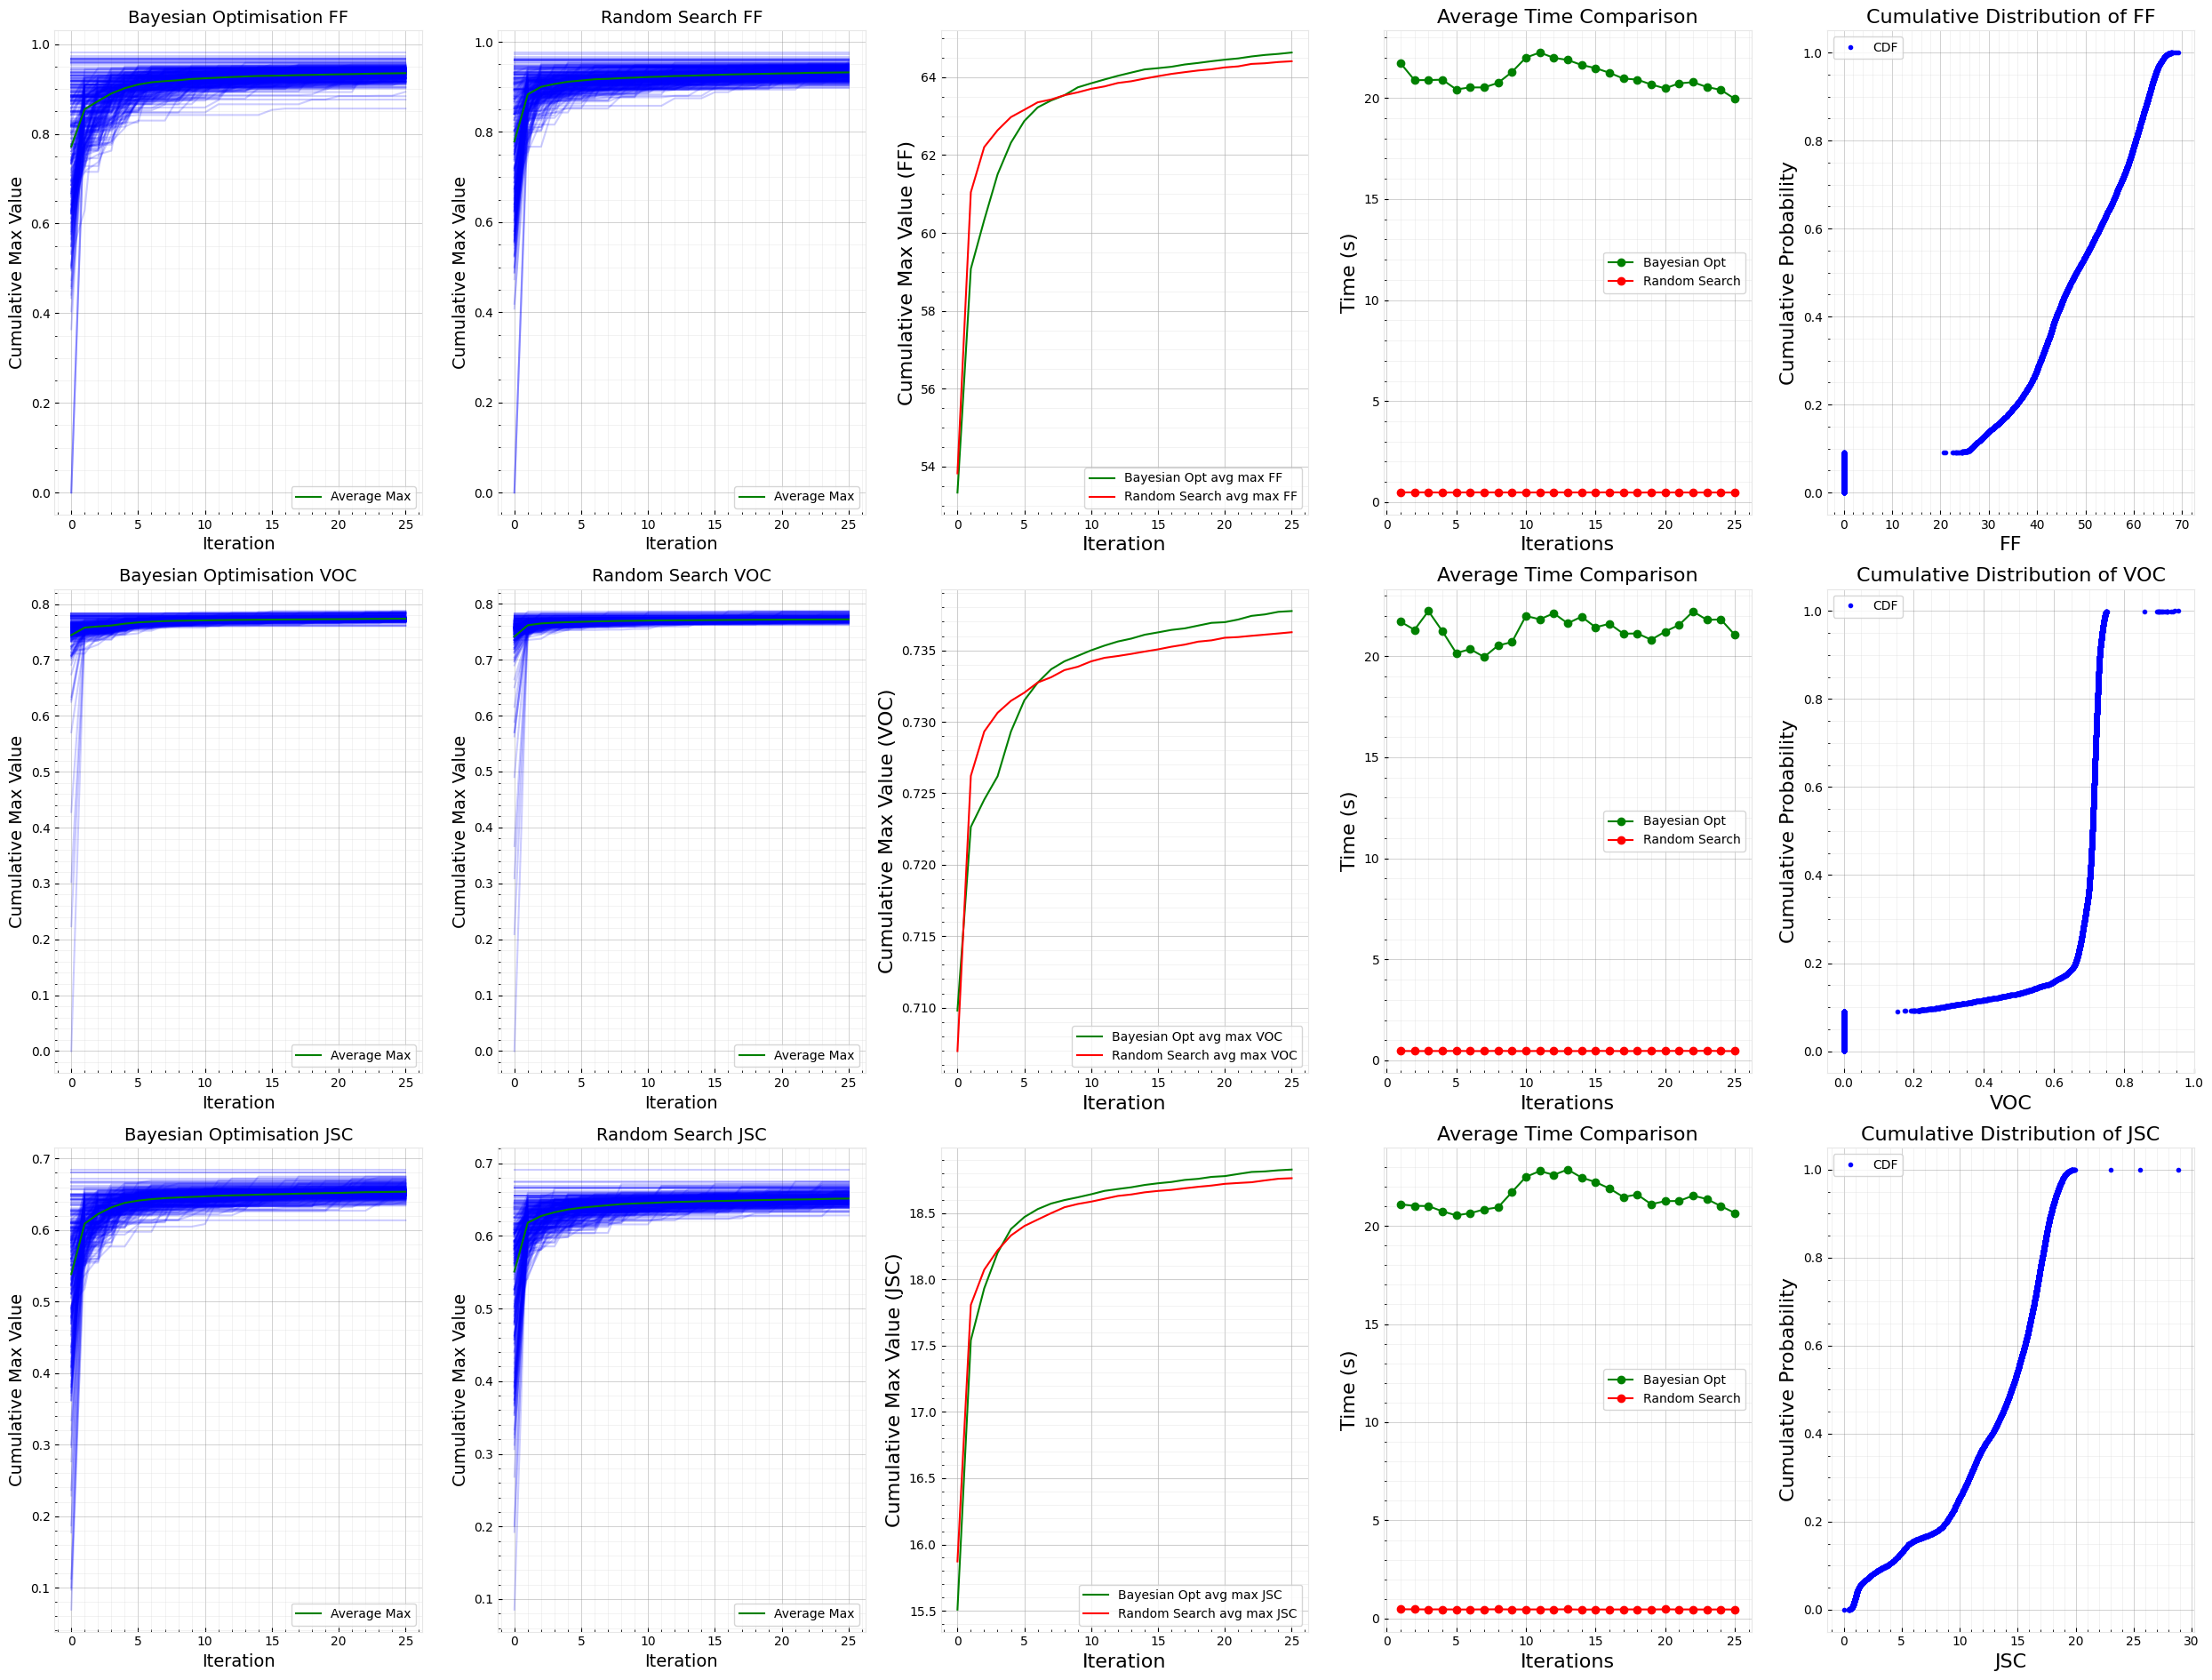

In [19]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 5, figsize=(25, 19))

visualize_max_iterations('Bayesian Opt Result FF', "Bayesian Optimisation FF", axes[0][0])
visualize_max_iterations('Random Search Result FF', "Random Search FF", axes[0][1])
visualize_max_iterations('Bayesian Opt Result VOC', "Bayesian Optimisation VOC", axes[1][0])
visualize_max_iterations('Random Search Result VOC', "Random Search VOC", axes[1][1])
visualize_max_iterations('Bayesian Opt Result JSC', "Bayesian Optimisation JSC", axes[2][0])
visualize_max_iterations('Random Search Result JSC', "Random Search JSC", axes[2][1])

visualize_max_iterations2('Bayesian Opt Result FF', 'green', 'Bayesian Opt avg max FF', axes[0][2], 'FF')
visualize_max_iterations2('Random Search Result FF', 'red', 'Random Search avg max FF', axes[0][2], 'FF')
visualize_max_iterations2('Bayesian Opt Result VOC', 'green', 'Bayesian Opt avg max VOC', axes[1][2], 'VOC')
visualize_max_iterations2('Random Search Result VOC', 'red', 'Random Search avg max VOC', axes[1][2], 'VOC')
visualize_max_iterations2('Bayesian Opt Result JSC', 'green', 'Bayesian Opt avg max JSC', axes[2][2], 'JSC')
visualize_max_iterations2('Random Search Result JSC', 'red', 'Random Search avg max JSC', axes[2][2], 'JSC')

plot_time(axes[0][3], 'Bayesian Opt Time FF', 'Bayesian Opt', 'o', 'green')
plot_time(axes[0][3], 'Random Search Time FF', 'Random Search', 'o', 'red')
plot_time(axes[1][3], 'Bayesian Opt Time VOC', 'Bayesian Opt', 'o', 'green')
plot_time(axes[1][3], 'Random Search Time VOC', 'Random Search', 'o', 'red')
plot_time(axes[2][3], 'Bayesian Opt Time JSC', 'Bayesian Opt', 'o', 'green')
plot_time(axes[2][3], 'Random Search Time JSC', 'Random Search', 'o', 'red')

plot_cdf(dataset_ff, axes[0][4], 'FF', ' c) Cumulative Distribution of FF')
plot_cdf(dataset_voc, axes[1][4], 'VOC', ' f) Cumulative Distribution of Voc')
plot_cdf(dataset_jsc, axes[2][4], 'JSC', ' i) Cumulative Distribution of Jsc')

plt.tight_layout()
plt.savefig("ALL.svg")

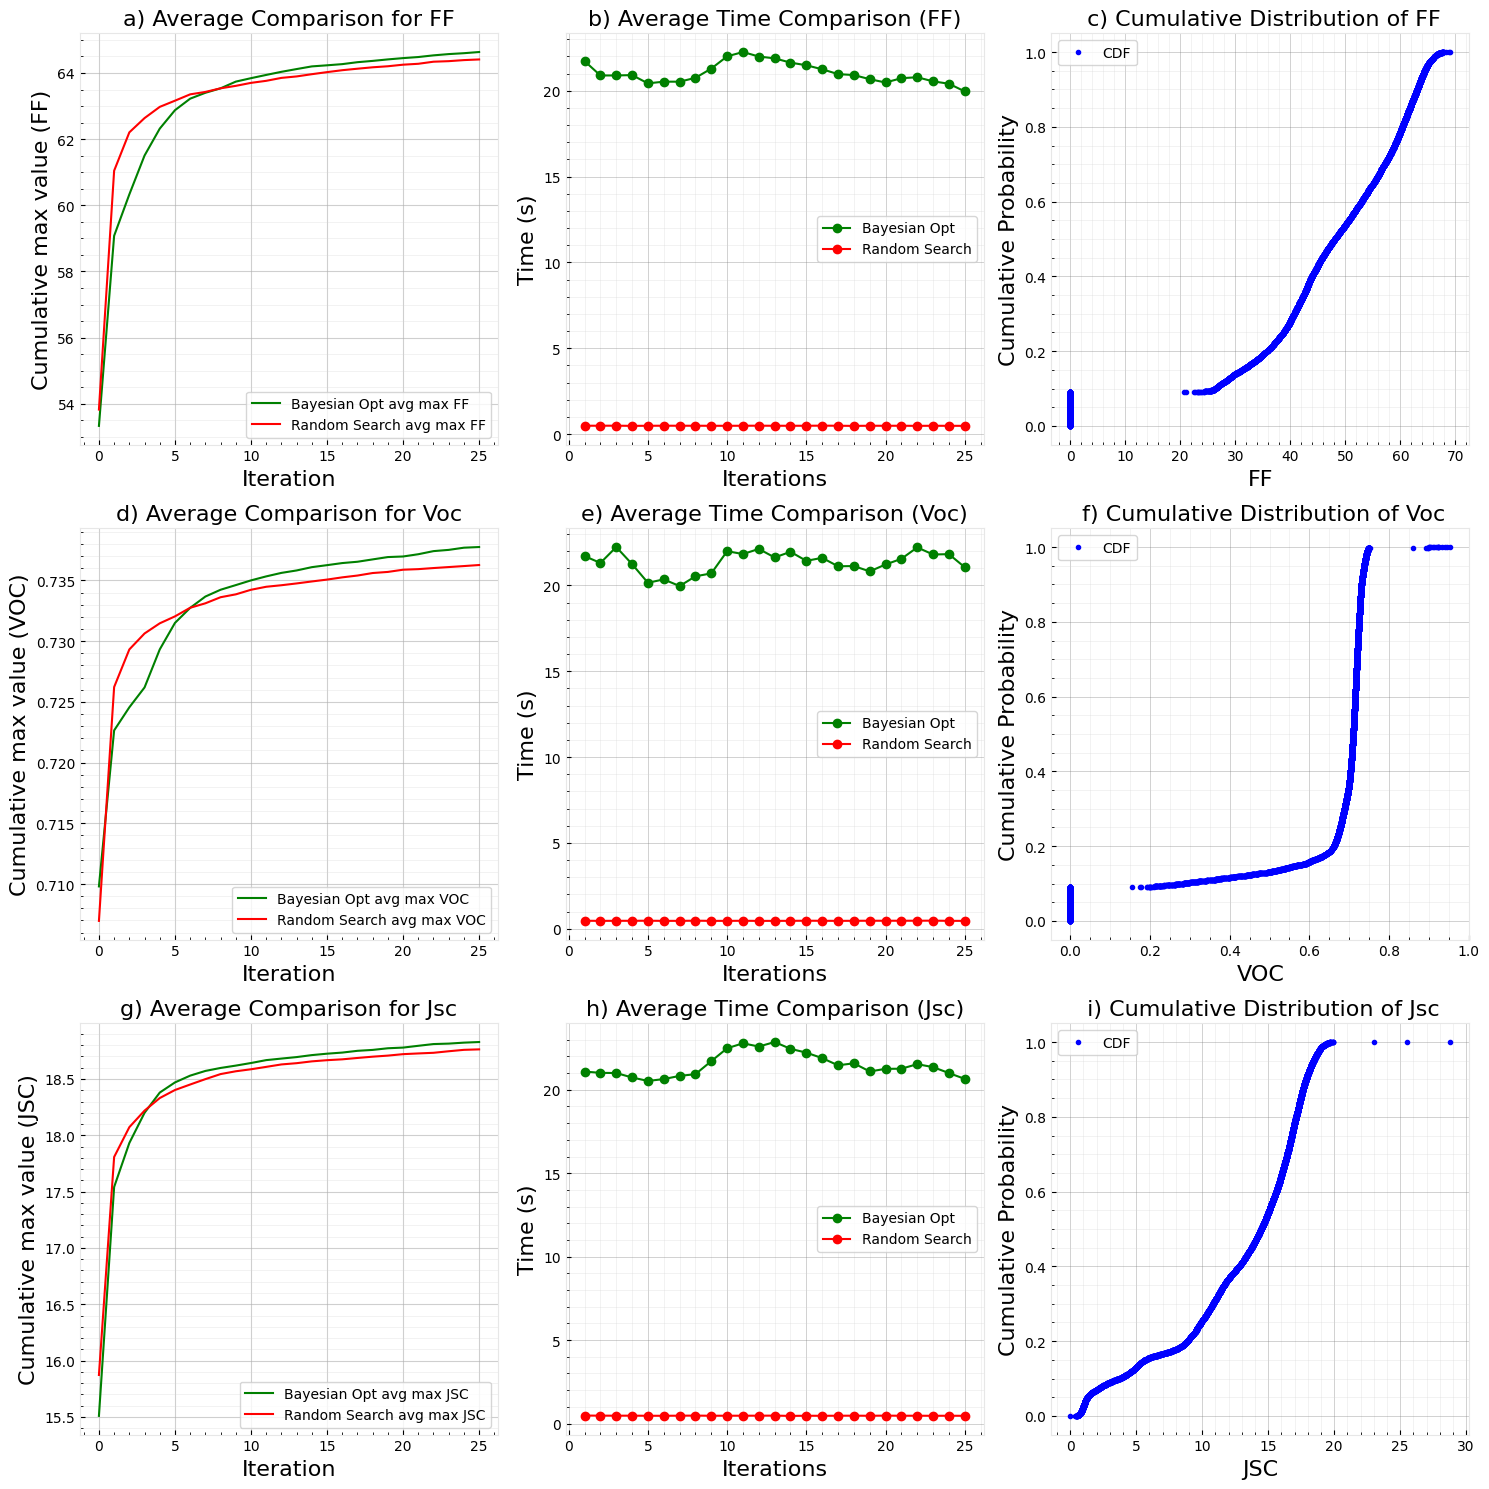

In [43]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

visualize_max_iterations2('Bayesian Opt Result FF', 'green', 'Bayesian Opt avg max FF', axes[0][0], 'FF', 'a) Average Comparison for FF')
visualize_max_iterations2('Random Search Result FF', 'red', 'Random Search avg max FF', axes[0][0], 'FF', 'a) Average Comparison for FF')
visualize_max_iterations2('Bayesian Opt Result VOC', 'green', 'Bayesian Opt avg max VOC', axes[1][0], 'VOC', 'd) Average Comparison for FF')
visualize_max_iterations2('Random Search Result VOC', 'red', 'Random Search avg max VOC', axes[1][0], 'VOC', 'd) Average Comparison for Voc')
visualize_max_iterations2('Bayesian Opt Result JSC', 'green', 'Bayesian Opt avg max JSC', axes[2][0], 'JSC', 'g) Average Comparison for FF')
visualize_max_iterations2('Random Search Result JSC', 'red', 'Random Search avg max JSC', axes[2][0], 'JSC', 'g) Average Comparison for Jsc')

plot_time(axes[0][1], 'Bayesian Opt Time FF', 'Bayesian Opt', 'o', 'green', 'Average Time Comparison (FF)')
plot_time(axes[0][1], 'Random Search Time FF', 'Random Search', 'o', 'red', 'b) Average Time Comparison (FF)')
plot_time(axes[1][1], 'Bayesian Opt Time VOC', 'Bayesian Opt', 'o', 'green', 'Average Time Comparison (FF)')
plot_time(axes[1][1], 'Random Search Time VOC', 'Random Search', 'o', 'red', 'e) Average Time Comparison (Voc)')
plot_time(axes[2][1], 'Bayesian Opt Time JSC', 'Bayesian Opt', 'o', 'green', 'Average Time Comparison (FF)')
plot_time(axes[2][1], 'Random Search Time JSC', 'Random Search', 'o', 'red', 'h) Average Time Comparison (Jsc)')

plot_cdf(dataset_ff, axes[0][2], 'FF', ' c) Cumulative Distribution of FF')
plot_cdf(dataset_voc, axes[1][2], 'VOC', ' f) Cumulative Distribution of Voc')
plot_cdf(dataset_jsc, axes[2][2], 'JSC', ' i) Cumulative Distribution of Jsc')

plt.tight_layout()
plt.savefig("ALL2.svg")

# Other Data Analysis

In [45]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

def find_value_for_percentile(df, percentile, item):
    value = np.percentile(df[item], 100 * (1 - percentile))
    return value

def get_average_max(folder):
    all_cumulative_max = {}
    all_cumulative_max[0] = []
    
    for filename in os.listdir(folder):
        if filename.endswith(".pkl"):
            file_path = os.path.join(folder, filename)
            with open(file_path, "rb") as f:
                X_sample, Y_sample = pickle.load(f)
            
            y = Y_sample
            batch_size = 25
            cumulative_max = [max(y[0], y[1])]
            iterations = [0]
            current_max = max(y[0], y[1])
            all_cumulative_max[0].append(current_max)
            
            for i in range(2, len(y), batch_size):
                batch_y = y[i:i+batch_size]
                iteration = (i // batch_size) + 1
                
                if len(batch_y) > 0:
                    max_y = max(batch_y)
                    current_max = max(current_max, max_y)
                    cumulative_max.append(current_max)
                    iterations.append(iteration)
                    
                    if iteration not in all_cumulative_max:
                        all_cumulative_max[iteration] = []
                    all_cumulative_max[iteration].append(current_max)
    
    # Compute and plot average max values across files
    avg_iterations = sorted(all_cumulative_max.keys())
    avg_cumulative_max = [np.mean(all_cumulative_max[it]) for it in avg_iterations]
    return avg_cumulative_max

def find_value_for_percentile(df, percentile, item):
    value = np.percentile(df[item], 100 * (1 - percentile))
    return value

def compute_average_time(folder):
    all_samples = []
    
    for filename in os.listdir(folder):
        if filename.endswith(".pkl"):
            file_path = os.path.join(folder, filename)
            with open(file_path, "rb") as f:
                Y_sample = pickle.load(f)
            
            all_samples.append(Y_sample)
    
    max_length = max(len(sample) for sample in all_samples)
    
    padded_samples = [np.pad(sample, (0, max_length - len(sample)), constant_values=np.nan) for sample in all_samples]
    
    all_samples_array = np.array(padded_samples, dtype=np.float64)
    average_values = np.nanmean(all_samples_array, axis=0)
    
    return average_values

In [49]:
for a in get_average_max('Bayesian Opt Result FF'):
    print(a)
print()
for a in get_average_max('Random Search Result FF'):
    print(a)

0.7718064783908396
0.8549801316618607
0.8730940586204321
0.8900951752370675
0.9018637786329987
0.9099256407608765
0.9149766389053539
0.917544216765228
0.919501122025592
0.9224319659415559
0.9239386974939979
0.9253589001121308
0.9267206052116819
0.9279250327455748
0.9290895096102031
0.929566916856783
0.9300812488903627
0.9309303751842054
0.9314968438294742
0.9321483793123541
0.9327137825123789
0.9331873805752043
0.9339190424854795
0.9344748848527541
0.9348632241470887
0.935376887899914

0.7789540708226245
0.8834494923742046
0.9002331385352109
0.9064747126479491
0.9113808205217041
0.914087120048406
0.9168631024881316
0.9179174387618501
0.9195040345329617
0.9205800620249405
0.9218825661123393
0.9227785854279102
0.924062142731789
0.9247014259200957
0.9256761016026452
0.9265845130710408
0.9274249427317326
0.9280795415891953
0.9286976175743272
0.9291494675221365
0.9298394843309439
0.9302308601507981
0.9311413130465941
0.931380480510407
0.9318451406469281
0.9321300701316952


In [50]:
for a in get_average_max('Bayesian Opt Result VOC'):
    print(a)
print()
for a in get_average_max('Random Search Result VOC'):
    print(a)

0.7444035824969751
0.7578766998031086
0.7598732073107228
0.7615879836432329
0.7648730498547374
0.7671616257863453
0.768461632840894
0.7694380997526002
0.7700263996790538
0.7704266773620478
0.7708345467429022
0.771179099035787
0.7714814369300635
0.7716917324598752
0.7719765802052482
0.7721492643943485
0.7723296419555427
0.7724430670011653
0.7726464300624822
0.7728477346713453
0.7728980396822765
0.7730927162052806
0.7733611975005679
0.7734682771597909
0.7736571285828269
0.7737148342799987

0.7414265793259535
0.7616233082469811
0.7648713004795563
0.7662488743100778
0.7671260745800459
0.7677258907719904
0.7684697152769936
0.7688544685888405
0.7693802618489449
0.7696277078316418
0.7700235531526164
0.7702831115802027
0.7704148671622199
0.7705706430886262
0.7707412132664888
0.7709028443222239
0.7710954896120442
0.7712518210201904
0.7714692943719937
0.7715648738728409
0.7717556708908967
0.7718049207750799
0.7718992518261237
0.7719846377849044
0.7720703334538995
0.7721611670762055


In [53]:
for a in get_average_max('Bayesian Opt Result JSC'):
    print(a)
print()
for a in get_average_max('Random Search Result JSC'):
    print(a)

0.5383955407518489
0.6089460548783543
0.6225135711821957
0.6318120704940328
0.6380492227953823
0.6411786580319282
0.6432689106963606
0.6447184394115201
0.6456364256457342
0.6463599217533045
0.6471600609073086
0.6480495522918276
0.6485272681747442
0.6489887460228354
0.6495978158513567
0.6500348639478413
0.6503751645640612
0.6509170821412682
0.6511984815967689
0.6517071167703159
0.6519141122290146
0.6524664875648949
0.6530015861527617
0.6531416911801974
0.6534385514360278
0.6536282833760638

0.5510074029220031
0.6181953432802433
0.6273879941341919
0.6324848376322791
0.6363607240035672
0.6388387152963813
0.6405340307968796
0.6421913039332632
0.6437502856243663
0.6446149478751583
0.6452302431032387
0.645970451276905
0.64672149925054
0.6471072918830619
0.6476692735063655
0.6480316319819551
0.6482940252933167
0.6487158542848664
0.649114385469764
0.6494425268862468
0.6498892772848793
0.6501104538851132
0.6503075175994896
0.6507834228486471
0.6512191129025994
0.6513644893524997


In [61]:
for a in list(compute_average_time("Bayesian Opt time FF")):
    print(a)
print()
for a in list(compute_average_time("Random Search time FF")):
    print(a)

21.723145486513772
20.88534031867981
20.886521650155384
20.90703625758489
20.42588979800542
20.524366725285848
20.523722966512043
20.747308594385782
21.285953555107117
21.999245267709096
22.250969815254212
21.988750459353128
21.882470324834188
21.634173848628997
21.479042023817698
21.247090117136636
20.963961677551268
20.91114452600479
20.668601627349855
20.47593076944351
20.726659194628397
20.781866159439087
20.542870123386383
20.40441537062327
19.956311059792835

0.4822043649355571
0.48452564954757693
0.4854199425379435
0.4756424363454183
0.4803575905164083
0.48424526770909626
0.48309304237365724
0.48249899784723915
0.48007931470870974
0.4794525949160258
0.4824988849957784
0.4856642500559489
0.48096540292104084
0.4815252391497294
0.48132843017578125
0.4879709545771281
0.4824136972427368
0.4736057329177856
0.48300175269444784
0.48058639764785765
0.48240822633107505
0.4760153023401896
0.48126984278361
0.4783589267730713
0.4767764099438985


In [63]:
for a in list(compute_average_time("Bayesian Opt time VOC")):
    print(a)
print()
for a in list(compute_average_time("Random Search time VOC")):
    print(a)

21.708416759967804
21.30690690835317
22.236039772033692
21.24063907066981
20.154627062479655
20.351075376669566
19.963296369711557
20.53114403883616
20.70057044585546
21.993349448839822
21.827317859331767
22.12462428331375
21.627910108566283
21.958056557973226
21.430991548697154
21.606698501904805
21.114215168952942
21.127846779823305
20.817366608778634
21.219135488669078
21.548400813738507
22.213657639026643
21.800822122097017
21.821035358905792
21.0590278339386

0.469725714524587
0.4632514691352844
0.46644069989522297
0.46713781356811523
0.4716328724225362
0.4633406368891398
0.46376264095306396
0.47302723010381065
0.4639334034919739
0.46242090861002605
0.46953279654184976
0.46166347980499267
0.4632421668370565
0.4651696554819743
0.4713374749819438
0.4677590847015381
0.46298317511876425
0.4672007099787394
0.4709579547246297
0.46947094678878787
0.4715114347139994
0.4704434943199158
0.47670560439427695
0.46476773341496785
0.46277097940444945


In [65]:
for a in list(compute_average_time("Bayesian Opt time JSC")):
    print(a)
print()
for a in list(compute_average_time("Random Search time JSC")):
    print(a)

21.09271858215332
21.016786881287892
21.00561195373535
20.73864802281062
20.531445883115133
20.642525429725648
20.833665171464283
20.937227658430736
21.717558589776356
22.489634548823037
22.787531972726185
22.592138461271922
22.863531913757324
22.454722004731497
22.226975863774616
21.899548364480335
21.467896596590677
21.588528967698416
21.099546442031862
21.25617892901103
21.26430587689082
21.536555875142415
21.360862730344138
21.00301849047343
20.65442327817281

0.4772109119097392
0.4734411891301473
0.46966081142425536
0.4721841311454773
0.4656150627136231
0.4646666383743286
0.47117449522018434
0.4752695655822754
0.4670609434445699
0.46902679999669394
0.46906580845514934
0.47094415505727133
0.4741809050242106
0.45820978164672854
0.46706801811854043
0.46391958395640054
0.46830738306045533
0.47057825485865273
0.4659034442901611
0.4743050154050191
0.4667896318435669
0.46844797134399413
0.4636576867103577
0.4677388127644857
0.46314885139465334
